In [8]:
import csv
from datetime import datetime
with open("data_daily.csv") as data_file:
        reader = csv.reader(data_file)
        next(reader)
        data = []
        for i in reader:
            data.append([datetime.strptime(i[0], "%Y-%m-%d"), int(i[1])])

C:\Users\aiden\AppData\Local\Temp/ipykernel_9804/1404483435.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


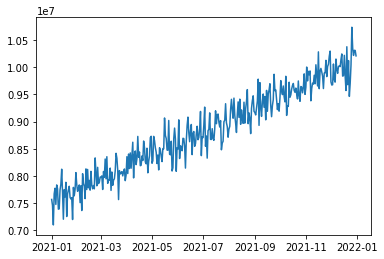

In [10]:
import matplotlib.pyplot as plt
import numpy as np
data = np.array(data)
fig,ax = plt.subplots()
ax.plot(data[:,0], data[:,1])
fig.show()

c:\Users\aiden\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\aiden\AppData\Local\Temp/ipykernel_9804/2686559867.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


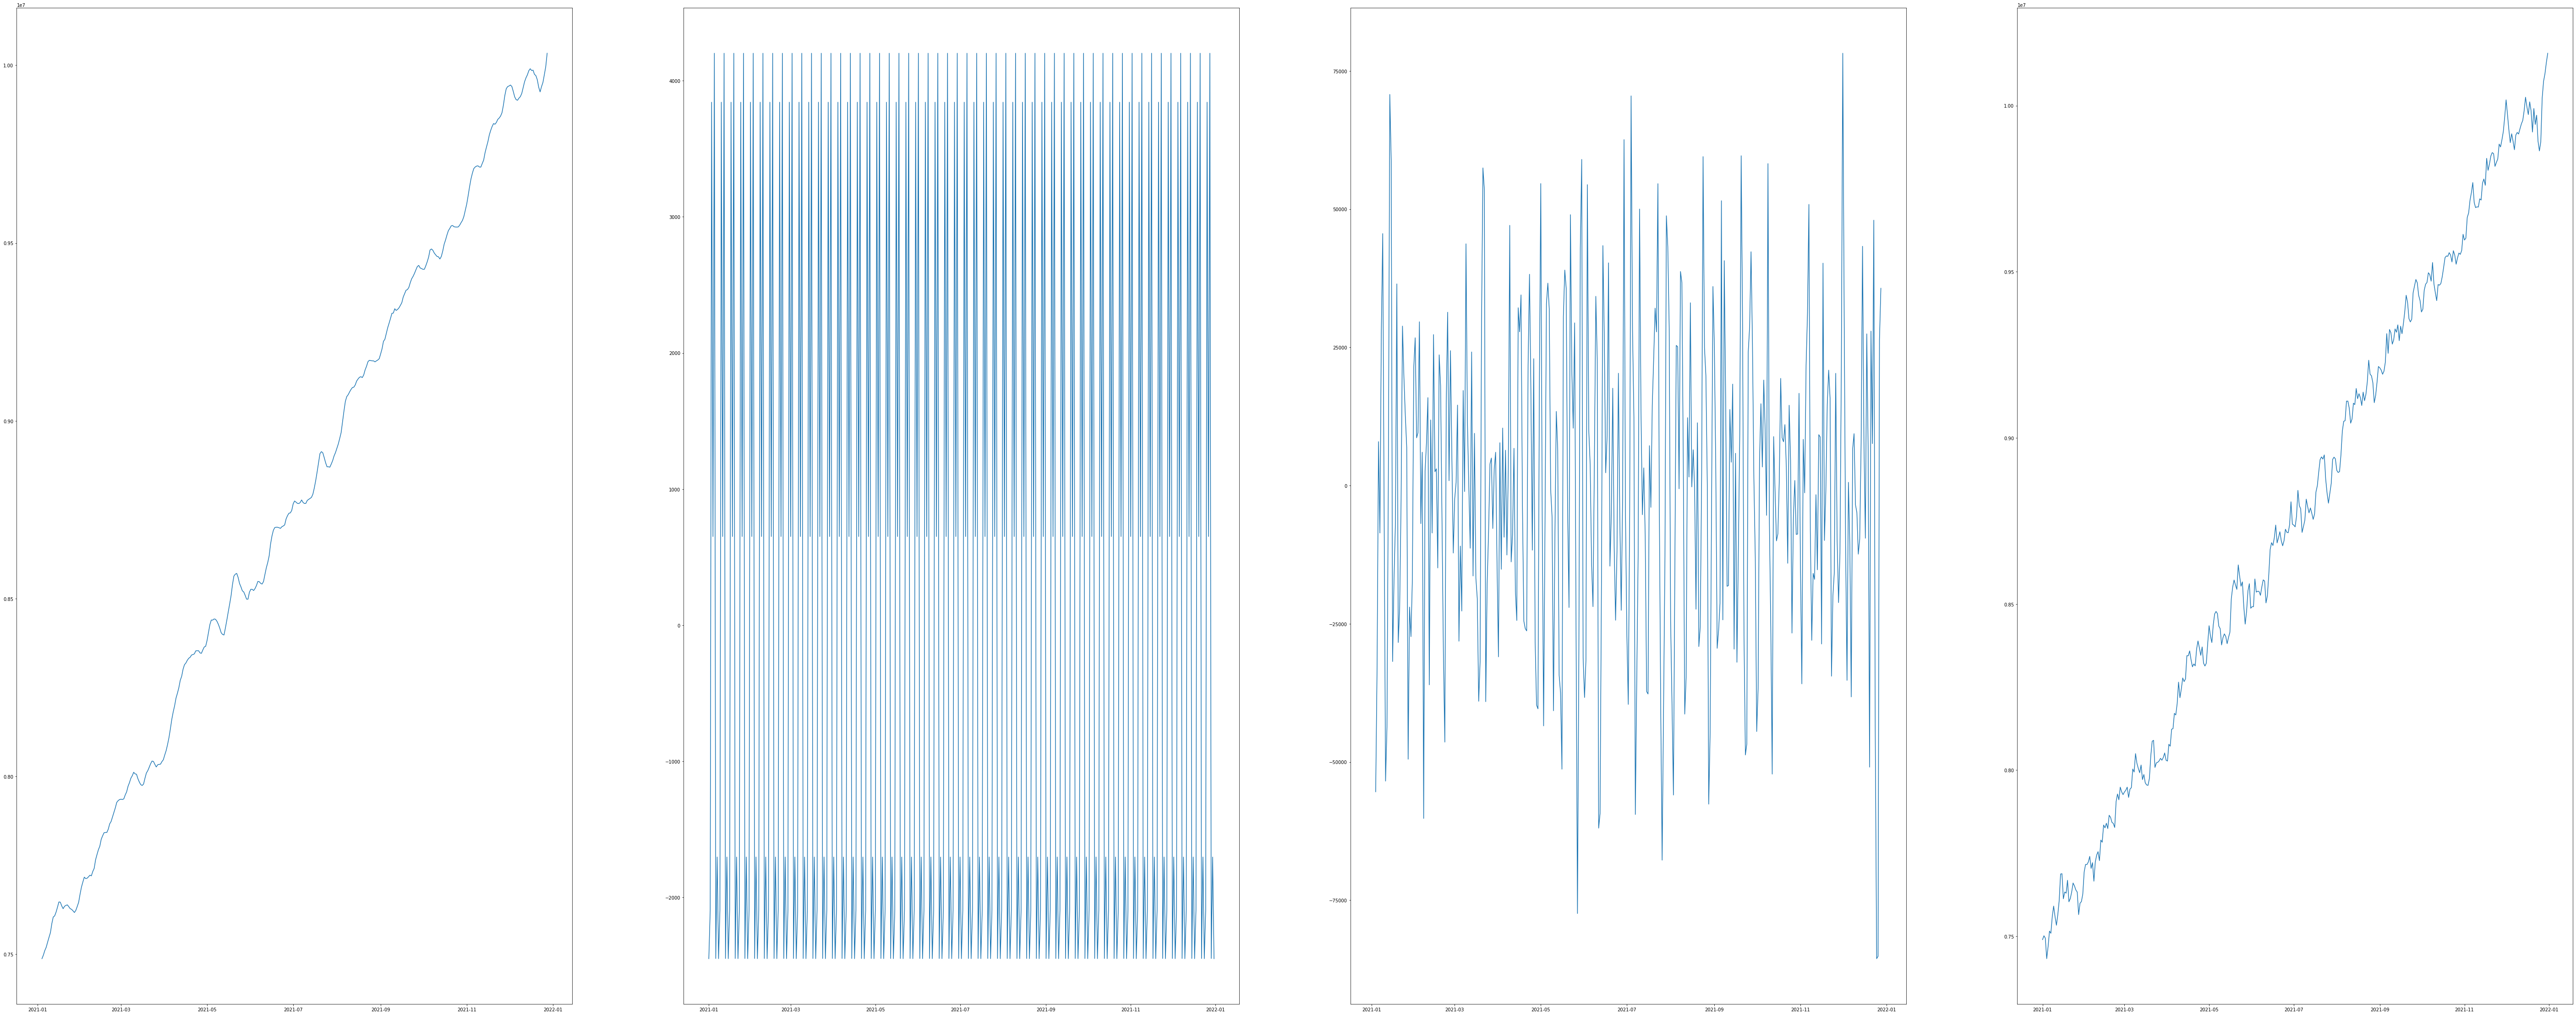

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
exp = ExponentialSmoothing(data[:,1]).fit()

# result = seasonal_decompose(data[:,1], model="additive", period=30)
result = seasonal_decompose(exp.fittedvalues, model="additive", period=7)
fig, ax = plt.subplots(1,4, figsize=(100,40))
ax[0].plot(data[:,0], result.trend)
ax[1].plot(data[:,0], result.seasonal)
ax[2].plot(data[:,0], result.resid)
ax[3].plot(data[:,0], result.observed)
fig.show()

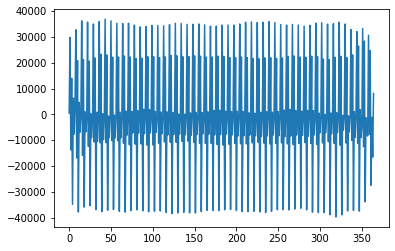

In [46]:
from scipy.fft import fft, ifft
ft = fft(result.seasonal)
t5 = [0  if not i in sorted(ft, reverse=True, key=lambda x: abs(x))[:100] else i for i in ft]
s = ifft(t5)
plt.plot([i for i in range(365)], s.real)
plt.show()

In [148]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import pandas as pd
plot_acf(data[:,1],lags=40)
plot_pacf(data[:,1])

a = ARIMA(np.array(result.observed,dtype=np.uint64), order=(1,1,2), seasonal_order=(1,1,1,30))
m = a.fit()
fig,ax = plt.subplots()
ax.plot(data[:,0],np.concatenate((data[:335,1] ,m.predict(start=336,end=365)), axis=0))
ax.plot(data[:,0], data[:,1], color="red")
fig.show()
print(m.summary())

TypeError: list indices must be integers or slices, not tuple

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import math
import keras_tuner as kt
from collections import defaultdict
 
def dtw_loss(y_true,y_pred):
    a = tf.map_fn(lambda x: dtw(x[0], x[1]), (y_true, y_pred), dtype=(tf.float32, tf.float32),  fn_output_signature=tf.float32)
    return tf.reduce_mean(a)

def dtw(y_true, y_pred):
    dp = defaultdict(lambda : np.inf)
    # dp = np.ones((y_true.shape[0], y_pred.shape[0]), dtype=np.float32) * np.inf
    # dp = [[float('inf') for i in range(tf.size(y_tr   ue))] for j in range(tf.size(y_pred))]
    x = y_true.shape[0]
    y = y_pred.shape[0]
    dp[0,0] = 0
    for i in range(1,x):
        for j in range(1,y):
            cost = tf.pow((tf.abs(y_true[i]-y_pred[j])),2)
            cost = tf.cast(cost,dtype=np.float32)
            dp[i,j] = tf.reshape(cost + tf.math.minimum(tf.math.minimum(dp[i-1,j], dp[i,j-1]), dp[i-1,j-1]),[])
    return dp[x-1,y-1]


class RNeuralNetwork:
    def __init__(self):
        self.model = models.Sequential([
            layers.LSTM(128, activation="relu"),
            layers.Dense(7, activation='linear', input_shape=(128,))

        ])  
    def build(self):
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss="mean_squared_error")
        return self.model  
    def fit(self,x_train,y_train):
        self.model = self.build()
        # self.model.fit(x_train, y_train, epochs=50, validation_split=0.2)
        self.model.fit(x_train, y_train, epochs=100)
        print(self.model.summary())

    def predict(self, X):
        return self.model.predict(X)
# class RNeuralNetwork:
#     def __init__(self):
#         self.tuner = kt.Hyperband(self.build,
#                     max_epochs=10,
#                     factor=3,
#                     objective="val_loss"
#                    )
#         self.model = None
#     def build(self,hp):
#         hp_units = hp.Int('units', min_value=10, max_value=32, step=2)

#         self.model = models.Sequential([
#             layers.SimpleRNN(hp_units, activation="relu"),
#             layers.Dense(9, activation='linear', input_shape=(hp_units,))

#         ])        
#         hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#         self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=dtw_loss)
#         return self.model

#     def fit(self,x_train,y_train):
#         stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#         self.tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])
#         best_hps = self.tuner.get_best_hyperparameters(num_trials=1)[0]
#         self.model = self.tuner.hypermodel.build(best_hps)
#         # self.model.fit(x_train, y_train, epochs=50, validation_split=0.2)
#         self.model.fit(x_train, y_train, epochs=50)
#         print(self.model.summary())

#     def predict(self, X):
#         return self.model.predict(X)

class NeuralNetwork:
    def __init__(self, size):
        self.size = size
        self.tuner = kt.Hyperband(self.build,
                    max_epochs=40,
                    factor=3,
                    objective="val_loss"
                   )
        self.model = None

    def build(self,hp):
        hp_units = hp.Int('units', min_value=1, max_value=32, step=2)
        model = models.Sequential([
        layers.Dense(hp_units, activation='relu', input_shape=(self.size,)),
        layers.Dense(1, activation='linear', input_shape=(10,))
        ])
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss="mean_squared_error")
        return model

    #fits data
    def fit(self,x_train,y_train):
        stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        self.tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])
        # self.tuner.search(x_train, y_train, epochs=50,  callbacks=[stop_early])
        best_hps = self.tuner.get_best_hyperparameters(num_trials=1)[0]
        self.model = self.tuner.hypermodel.build(best_hps)
        self.model.fit(x_train, y_train, epochs=50, validation_split=0.2)
        print(self.model.summary())
    #predict from row
    def predict(self, X):
        return self.model.predict(X)
class SlidingWindowTransform:
    def __init__(self, size):
        self.size = size
    def transform(self,data):
        newdata = np.zeros((data.shape[0]-self.size, self.size))
        for i in range(self.size,data.shape[0]):
            newdata[i-self.size,:] = data[i-self.size:i,1]
        return pd.DataFrame(newdata, columns=[f"Data{i}" for i in range(self.size)] )


In [2]:
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pandas.tseries.holiday import USFederalHolidayCalendar
import copy
import numpy as np
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2021-01-01', end='2022-12-31').to_pydatetime()

import csv
with open("data_daily.csv") as data_file:
    reader = csv.reader(data_file)
    next(reader)
    data = []
    for i in reader:
        data.append(i)
    data = [[datetime.strptime(i[0],"%Y-%m-%d") , int(i[1])] for i in data]
    scaler = MinMaxScaler((-1,1))
    data = np.array(data)
    scaler.fit(data[:,1].reshape(-1,1))

    data[:,1] = scaler.transform(data[:,1].reshape(-1,1)).flatten()
    olddata = copy.deepcopy(data)
    data[:,1] = data[:,1] - np.append([0],data[:,1][:-1])

    df = SlidingWindowTransform(8).transform(data)
    
    Y = df.iloc[:,1:].to_numpy()
    X= df.iloc[:,:df.shape[1]-1].to_numpy()
    newX = np.zeros((X.shape[0], X.shape[1], 5))

    for i in range(len(X)):
        for j in range(len(X[i])):
            newX[i,j,:] = [X[i,j], np.mean(data[:i+j+1,1]), np.std(data[:i+j+1,1]), int(data[i+j,0] in holidays), data[i+j,0].weekday()  ]
    testX = newX[365-30:]
    testY = Y[365-30:]
    newX = newX[:365-30]
    Y = Y[:365-30]
    X = X[:365-30]
    Y = Y.reshape((Y.shape[0],Y.shape[1],1))
    X = X.reshape((X.shape[0], X.shape[1],1))
    # dtw_loss(newX,Y)
    print(newX[0,:,:])
    print(Y[0,:,:])
    nn = RNeuralNetwork()
    nn.fit(newX,Y)
    # samp = [9608834,9893666,9897017,10129048,9828852,10014982,10057900,10204676,10299217]
    # pred_row = np.array(samp + [np.mean(samp)]).reshape(1,9,1)
    # # pred_row = np.log(pred_row)
    # # print(nn.predict(pred_row))

[[-0.74235855 -0.74235855  0.          1.          4.        ]
 [-0.05996622 -0.40116239  0.34119616  0.          5.        ]
 [-0.19767523 -0.33333333  0.29463781  0.          6.        ]
 [ 0.31330132 -0.17167467  0.37882602  0.          0.        ]
 [ 0.05770683 -0.12579837  0.35103541  0.          1.        ]
 [-0.16356416 -0.13209267  0.32075896  0.          2.        ]
 [ 0.19723279 -0.08504618  0.31854121  0.          3.        ]]
[[-0.05996622]
 [-0.19767523]
 [ 0.31330132]
 [ 0.05770683]
 [-0.16356416]
 [ 0.19723279]
 [-0.03710548]]
Epoch 1/100
11/11 [==============================] - 1s 5ms/step - loss: 0.0323
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0282
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0268
Epoch 4/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0264
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0263
Epoch 6/100
11/11 [==============================] -

In [3]:
import copy
import random

# n = []
# curr = np.array([9608834,9893666,9897017,10129048,9828852,10014982,10057900,10204676,10299217]).reshape(-1,1)
# curr = scaler.transform(curr)
# for i in range(30):
#     res = nn.predict(curr.reshape(1,9,1)).flatten()
#     n.append(res[0])
#     curr = np.append(curr[1:],res)
#     print(curr)
news = []
new = newX[-1, :].reshape(1,7,5)
past2 = data[:,1]
for i in range(365):
    new = new.reshape(1,7,5) 
    for i in range(len(new[0])):
        new[0,i,0] += random.uniform(-0.05,.05)
    res = nn.predict(new)
    np.append(past2, [res[-1][-1]])
    new = np.append(new[0,1:], [[res[-1][-1] , np.mean(past2 ), np.std(past2), 0, 0]], axis=0)
    news.append(res[-1])

print(news)

1/1 [==============================] - 0s 15ms/step
[array([-0.00148225,  0.01015482,  0.24621466, -0.16537948, -0.013595  ,
        0.25950536, -0.17191854], dtype=float32), array([ 0.02138602,  0.264343  , -0.20183763, -0.0333915 ,  0.23173515,
       -0.16286835,  0.02096083], dtype=float32), array([ 0.19266409, -0.1542072 , -0.05274588,  0.22192532, -0.12549129,
        0.03746976, -0.02994013], dtype=float32), array([-0.19560158,  0.01387245,  0.12539597, -0.04810483, -0.02717352,
       -0.09782237,  0.11524401], dtype=float32), array([ 0.0347624 ,  0.1303243 , -0.11058737,  0.04317374, -0.09114395,
        0.05900721, -0.00688697], dtype=float32), array([ 0.20147188, -0.0322771 , -0.05542624,  0.02163945,  0.03032993,
       -0.03592826, -0.02827623], dtype=float32), array([ 0.03610228, -0.03312749, -0.0694823 ,  0.07567426,  0.01525525,
       -0.03210944, -0.01176542], dtype=float32), array([ 0.0637007 , -0.08211084, -0.04449978,  0.07878053,  0.01377773,
       -0.06230812,  

11/11 [==============================] - 0s 2ms/step
[[-0.04622608 -0.2256149   0.28940278 ... -0.17060363  0.18750307
  -0.02985593]
 [-0.17713442  0.32290417  0.05652679 ...  0.21909112 -0.03105351
  -0.11430298]
 [ 0.32443252  0.05522453 -0.1640895  ... -0.03568387 -0.20397452
   0.05492747]
 ...
 [ 0.06387077 -0.24679519 -0.03340981 ...  0.24170747 -0.15838878
   0.07941392]
 [-0.2547534   0.01355576  0.00330011 ... -0.16162246 -0.04122402
   0.07411121]
 [-0.00148221  0.01015475  0.2462145  ... -0.01359511  0.2595053
  -0.17191857]]
22


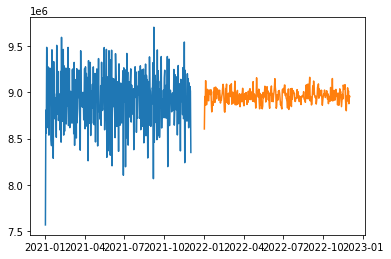

<Figure size 2880x2880 with 0 Axes>

In [4]:
from datetime import date
import matplotlib.pyplot as plt
res = nn.predict(newX)

print(res)
print(len(testX))

fig,ax = plt.subplots()
# data=np.array(data)
# total = np.array([])
# for i in range(0,365):
#     total = np.append(total,news[i][-1])
# total = total[:365]
data=data[:335]
plt.figure(figsize=(40,40))
ax.plot(data[:,0], scaler.inverse_transform(data[:,1].reshape(-1,1)))
# ax.plot([i.replace(year=i.year + 1) for i in data[:,0]], scaler.inverse_transform(np.array([i[-1] for i in news[:335]]).reshape(-1,1)))
n = np.array([B[0,0]+i*B[1,0]+ (i**2)*B[2,0] + (i**3)*B[3,0] for i in range(len(data))]).flatten() + np.array([i[-1] for i in news][:335]).reshape(-1,1)

ax.plot([i.replace(year=i.year + 1) for i in data[:,0]],  scaler.inverse_transform())


[[-0.04622608 -0.2256149   0.28940278 ... -0.17060363  0.18750307
  -0.02985593]
 [-0.17713442  0.32290417  0.05652679 ...  0.21909112 -0.03105351
  -0.11430298]
 [ 0.32443252  0.05522453 -0.1640895  ... -0.03568387 -0.20397452
   0.05492747]
 ...
 [ 0.06387077 -0.24679519 -0.03340981 ...  0.24170747 -0.15838878
   0.07941392]
 [-0.2547534   0.01355576  0.00330011 ... -0.16162246 -0.04122402
   0.07411121]
 [-0.00148221  0.01015475  0.2462145  ... -0.01359511  0.2595053
  -0.17191857]]
[[-0.7641040048013453]
 [0.0041654114001032205]
 [-2.405046283124668e-06]
 [5.1815439136602524e-09]]
(365,)


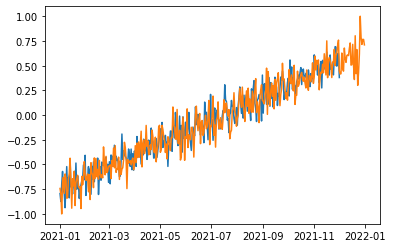

In [20]:
import matplotlib.pyplot as plt
terms = [lambda x: np.ones(x.shape) , lambda x: x, lambda x: np.square(x), lambda x:np.power(x,3) ]
X = [i(np.array([j for j in range(len(olddata))])) for i in terms]
X = np.array(X).transpose()
B = np.linalg.inv(X.transpose() @ X)@X.transpose()@olddata[:,1].reshape(-1,1)
print(res)
B
fig,ax = plt.subplots()

n = np.array([B[0,0]+i*B[1,0]+ (i**2)*B[2,0] + (i**3)*B[3,0] for i in range(len(data))]).flatten() + np.array([i[-1] for i in res]).flatten()
ax.plot(olddata[:,0][:335], n)
ax.plot(olddata[:,0], olddata[:,1])
print(B)
print(olddata[:,0].shape)

In [22]:
from datetime import timedelta
import pickle
import io
import base64
from ml import OLS, RNeuralNetwork
def getOldData():
    with open("data_daily.csv") as data_file:
        reader = csv.reader(data_file)
        next(reader)
        data = []
        for i in reader:
            data.append(i)
        data = [[datetime.strptime(i[0],"%Y-%m-%d") , int(i[1])] for i in data]
    return np.array(data)
def getData():
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start='2021-01-01', end='2022-12-31').to_pydatetime()
    # Read Data from file
    with open("data_daily.csv") as data_file:
        reader = csv.reader(data_file)
        next(reader)
        data = []
        for i in reader:
            data.append(i)
        data = [[datetime.strptime(i[0],"%Y-%m-%d") , int(i[1])] for i in data]
        scaler = MinMaxScaler((-1,1))
        data = np.array(data)
        scaler.fit(data[:,1].reshape(-1,1))
        pickle.dump(scaler, open("scaler.pkl", "wb"))

        olddata = copy.deepcopy(data[:,1])
        data[:,1] = scaler.transform(data[:,1].reshape(-1,1)).flatten()
        # Remove Trend from data
        data[:,1] = data[:,1] - np.append([0],data[:,1][:-1])
        # Transform data and add Features
        df = SlidingWindowTransform(8).transform(data)
        Y = df.iloc[:,1:].to_numpy()
        X= df.iloc[:,:df.shape[1]-1].to_numpy()
        newX = np.zeros((X.shape[0], X.shape[1], 5))
        for i in range(len(X)):
            for j in range(len(X[i])):
                newX[i,j,:] = [X[i,j], np.mean(data[:i+j+1,1]), np.std(data[:i+j+1,1]), int(data[i+j,0] in holidays), data[i+j,0].weekday()  ]
        return newX, Y
def runModels():
    data = predict(int(3))
    olddata = getOldData()
    fig,ax = plt.subplots()
    fig.subplots_adjust(bottom=.100)

    ax.plot(olddata[:,0], olddata[:,1])
    times = [datetime(2022, 1, 1) + timedelta(days=i) for i in range(len(data))]
    ax.plot(times, data)
    b = io.BytesIO()
    plt.savefig(b, format="png")
    b.seek(0)
    b = base64.b64encode(b.read()).decode()
    resp = {}
    resp["image"] = b
    resp["total"] = np.sum(data)
    return resp
def predict(months):
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start='2021-01-01', end='2022-12-31').to_pydatetime()
    newX,Y = getData()
    data = getOldData()
    scaler = pickle.load(open("scaler.pkl","rb"))
    data[:,1] = scaler.transform(data[:,1].reshape(-1,1)).flatten()

    nn = RNeuralNetwork()
    nn.load()
    linear_model = OLS()
    linear_model.load()
    new_rows = []
    new = newX[-1, :].reshape(1,newX.shape[1],5)
    past2 = data[:,1]
    days = [31,28,31,30,31,30,31,31,30,31,30,31]
    jan = datetime(2022,1,1)
    for i in range(sum(days[:months])):
        new = new.reshape(1,7,5) 
        for i in range(len(new[0])):
            new[0,i,0] += random.uniform(-0.05,.05)
        res = nn.predict(new)
        np.append(past2, [res[-1][-1]])
        new = np.append(new[0,1:], [[res[-1][-1] , np.mean(past2 ), np.std(past2),  int(jan in holidays), jan.weekday()]], axis=0)
        jan += timedelta(days=1)
        new_rows.append(res[-1])
        B = linear_model.weights

        n = np.array([B[0,0]+i*B[1,0]+ (i**2)*B[2,0] + (i**3)*B[3,0] for i in range(len(data))]).flatten() + np.array([i[-1] for i in res]).flatten()

    return n

runModels()

ValueError: Layer 'lstm_cell' expected 3 variables, but received 0 variables during loading. Expected: ['lstm/lstm_cell/kernel:0', 'lstm/lstm_cell/recurrent_kernel:0', 'lstm/lstm_cell/bias:0']